In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style('darkgrid')

In [2]:
dataset = pd.read_csv('/kaggle/input/carspricedataset/train.csv')
dataset = dataset[dataset['Price'] < 600000].reset_index()
dataset = dataset[dataset['Price'] > 10].reset_index()

In [3]:
def prepare_df(df, levy_median = 781):
    df['Turbo'] = df['Engine volume'].str.contains(' Turbo').astype(int) # Adding extra feature
    
    df['Leather interior'] = (df['Leather interior'] == 'Yes').astype(int) #category to numeric
    
    df['Levy'] = df['Levy'].replace({'-': np.nan}).astype(float)
    df['Levy'] = df['Levy'].fillna(levy_median) #replace with median
    
    df['Mileage'] = df['Mileage'].str.replace('km','').astype(float) # Separating text
    
    df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '').astype(float)
    
    df = df.drop(['Manufacturer', 'Model','Doors', 'level_0', 'index', 'ID'], axis=1)
    
    return df

In [4]:
dataset = prepare_df(dataset)
dataset

,Price,Levy,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags,Turbo
0,13328,1399.0,2010,Jeep,1,Hybrid,3.5,186005.0,6.0,Automatic,4x4,Left wheel,Silver,12,0
1,16621,1018.0,2011,Jeep,0,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,Left wheel,Black,8,0
2,8467,781.0,2006,Hatchback,0,Petrol,1.3,200000.0,4.0,Variator,Front,Right-hand drive,Black,2,0
3,3607,862.0,2011,Jeep,1,Hybrid,2.5,168966.0,4.0,Automatic,4x4,Left wheel,White,0,0
4,11726,446.0,2014,Hatchback,1,Petrol,1.3,91901.0,4.0,Automatic,Front,Left wheel,Silver,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19205,8467,781.0,1999,Coupe,1,CNG,2.0,300000.0,4.0,Manual,Rear,Left wheel,Silver,5,1
19206,15681,831.0,2011,Sedan,1,Petrol,2.4,161600.0,4.0,Tiptronic,Front,Left wheel,Red,8,0
19207,26108,836.0,2010,Jeep,1,Diesel,2.0,116365.0,4.0,Automatic,Front,Left wheel,Grey,4,0
19208,5331,1288.0,2007,Jeep,1,Diesel,2.0,51258.0,4.0,Automatic,Front,Left wheel,Black,4,0


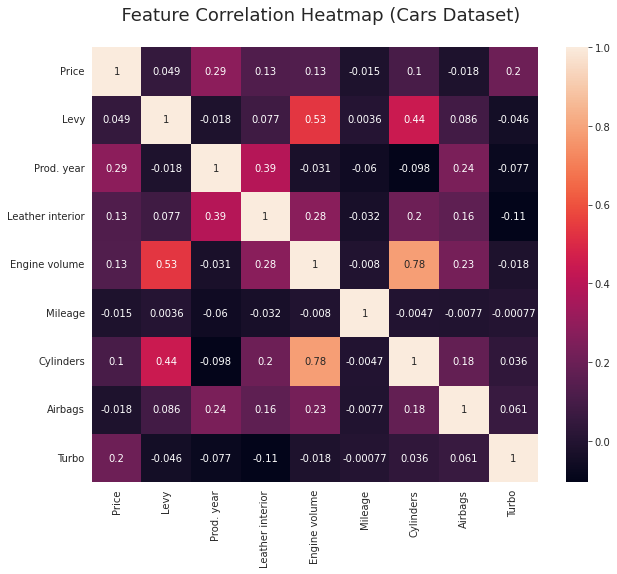

In [5]:
corr = dataset.corr()

heatmap = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0) 
heatmap.set_title('  Feature Correlation Heatmap (Cars Dataset)\n', fontsize=18)
plt.show()

In [6]:
def one_hot_by_column_name(df, col_name):
    df = df.copy()
    df = pd.concat([df, pd.get_dummies(df[col_name], prefix=col_name)],axis=1).drop([col_name],axis = 1)
    return df

dataset = one_hot_by_column_name(dataset, 'Category')
dataset = one_hot_by_column_name(dataset, 'Fuel type')
dataset = one_hot_by_column_name(dataset, 'Gear box type')
dataset = one_hot_by_column_name(dataset, 'Drive wheels')
dataset = one_hot_by_column_name(dataset, 'Wheel')
dataset = one_hot_by_column_name(dataset, 'Color')

In [7]:
Y = dataset[['Price']]
X = dataset.drop(columns=['Price'])

display(Y)
display(X)

X = X.values
Y = Y.values.ravel()
Y = (Y- Y.min()) / (Y.max() - Y.min())

test_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=0)

,Price
0,13328
1,16621
2,8467
3,3607
4,11726
...,...
19205,8467
19206,15681
19207,26108
19208,5331


,Levy,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Airbags,Turbo,Category_Cabriolet,Category_Coupe,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,1399.0,2010,1,3.5,186005.0,6.0,12,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1018.0,2011,0,3.0,192000.0,6.0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,781.0,2006,0,1.3,200000.0,4.0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,862.0,2011,1,2.5,168966.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,446.0,2014,1,1.3,91901.0,4.0,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19205,781.0,1999,1,2.0,300000.0,4.0,5,1,0,1,...,0,0,0,0,0,0,1,0,0,0
19206,831.0,2011,1,2.4,161600.0,4.0,8,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19207,836.0,2010,1,2.0,116365.0,4.0,4,0,0,0,...,0,1,0,0,0,0,0,0,0,0
19208,1288.0,2007,1,2.0,51258.0,4.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
def train_and_calculate_performance(clf):
    clf.fit(X_train, y_train)

    train_output = clf.predict(X_train)
    test_output = clf.predict(X_test)

    print('Train score:', clf.score(X_train, y_train))
    print('Test score:', clf.score(X_test, y_test))

    train_mae = mean_absolute_error(y_train, train_output)
    train_mse = mean_squared_error(y_train, train_output)

    test_mae = mean_absolute_error(y_test, test_output)
    test_mse = mean_squared_error(y_test, test_output)

    display(pd.DataFrame({'MAE': [train_mae, test_mae], 'MSE': [train_mse, test_mse]}, index=['Train', 'Test']))

In [10]:
clf = KNeighborsRegressor()
train_and_calculate_performance(clf)

Train score: 0.398488487302729
Test score: 0.1367033510704716


,MAE,MSE
Train,0.027379,0.002156
Test,0.033583,0.002916


In [11]:
clf = SVR()
train_and_calculate_performance(clf)

Train score: -0.5693153305184813
Test score: -0.5994617436213139


,MAE,MSE
Train,0.063518,0.005626
Test,0.063347,0.005403


In [12]:
clf = DecisionTreeRegressor(random_state=0)
train_and_calculate_performance(clf)

Train score: 0.9894035381368954
Test score: 0.4636988771624523


,MAE,MSE
Train,0.000611,0.000038
Test,0.019121,0.001812


In [13]:
clf = RandomForestRegressor(random_state=0)
train_and_calculate_performance(clf)

Train score: 0.9509550957858252
Test score: 0.7068092622193878


,MAE,MSE
Train,0.006053,0.000176
Test,0.015575,0.000990


In [14]:
clf = AdaBoostRegressor(random_state=0)
train_and_calculate_performance(clf)

Train score: -0.11047282384554613
Test score: -0.2060841036692882


,MAE,MSE
Train,0.054189,0.003981
Test,0.054362,0.004074


In [15]:
clf = GradientBoostingRegressor(random_state=0)
train_and_calculate_performance(clf)

Train score: 0.648303550576292
Test score: 0.5877465743897892


,MAE,MSE
Train,0.021914,0.001261
Test,0.023045,0.001393
